# Experiment 1: Problem of unbalanced data

### One class classification vs Binary classification

In [18]:
#import depencies
import h5py
import itertools
import json
import os
import sys
from pathlib import Path

try:
    # Get the current working directory
    current_dir = os.getcwd()

    # Set the root directory to the parent of the current directory
    root_dir = os.path.dirname(os.path.dirname(current_dir))

    # Add the root directory to sys.path so Python can find the utils module
    sys.path.append(str(root_dir))

    # Standard libraries
    import numpy as np
    import pandas as pd
    from IPython.display import display
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    import matplotlib.pyplot as plt
    import pywt
    import seaborn as sns
    from scipy import signal, stats
    from sklearn.ensemble import IsolationForest, RandomForestClassifier
    from sklearn.metrics import (
        accuracy_score,
        classification_report,
        confusion_matrix,
        ConfusionMatrixDisplay,
        f1_score,
        make_scorer,
        precision_score,
        recall_score
    )
    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import OneClassSVM
    from tqdm import tqdm

    # Custom utilities
    from utils.feature_extraction import transform_data
    from utils.load_data import load_data
    from utils.result_utils import create_results_df, record_result

    print("Dependencies loaded successfully ✅")
except Exception as e:
    print(f"Error loading dependencies: {e}")

Dependencies loaded successfully ✅


In [19]:
#0 == good | 1 == bad |
X, y, y_binary = load_data()

Loading data: 100%|██████████| 90/90 [00:16<00:00,  5.50it/s, Samples=1702]

Data loaded successfully ✅ - 1702 samples


### Experiment 1.1: One Class Classification (OneClassSVM)

Extracting features:   0%|          | 0/1276 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/426 [00:00<?, ?it/s]

Class distribution of testy:
Class 0: 408 samples (95.77%)
Class 1: 18 samples (4.23%)
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best score: 0.000
F1 Score: 0.296


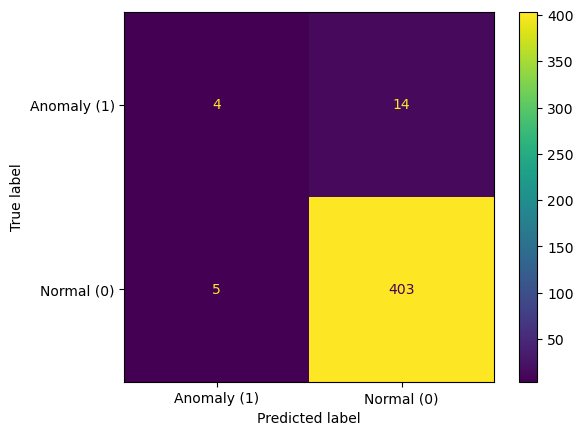

In [20]:
# Split data into training (80%) and testing (20%) sets while maintaining class distribution
trainX, testX, trainy, testy = train_test_split(X, y_binary, test_size=0.25, random_state=42, stratify=y_binary)

# Extract features from raw data for both training and testing sets
trainX_tr, trainy_tr = transform_data(trainX, trainy, label_type='binary')
testX_tr, testy_tr = transform_data(testX, testy, label_type='binary')

# Print class distribution of testy
unique, counts = np.unique(testy, return_counts=True)
print("Class distribution of testy:")
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(testy)*100:.2f}%)")

# Define parameter grid for OneClassSVM
param_grid = {
    'gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    'nu': [0.01, 0.05, 0.1, 0.2],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Create a custom scorer for OneClassSVM
def custom_ocsvm_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    # Convert predictions: 1 (inlier) -> 0, -1 (outlier) -> 1
    y_pred_converted = np.where(y_pred == 1, 0, 1)
    return f1_score(y, y_pred_converted, pos_label=1)

# Filter training data to only include normal samples (class 0)
trainX_0 = trainX_tr[trainy_tr==0]

# Perform grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    OneClassSVM(),
    param_grid,
    cv=3,
    scoring=custom_ocsvm_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the normal data
grid_search.fit(trainX_0, trainy_tr[trainy_tr==0])

# Get the best parameters
best_params_OCSVM = grid_search.best_params_
print(f"Best parameters: {best_params_OCSVM}")
print(f"Best score: {grid_search.best_score_:.3f}")

# Initialize One-Class SVM model with best parameters
model = OneClassSVM(**best_params_OCSVM)

# Train the model on normal samples only
model.fit(trainX_0)

# Make predictions on test data
# OneClassSVM returns: 1 for inliers (normal), -1 for outliers (anomalies)
yhat = model.predict(testX_tr)

# Convert ground truth labels to match OneClassSVM output format:
# -1 for anomalies (class 1), 1 for normal (class 0)
yhat_converted = np.array(yhat.copy())
# Then apply the conversion
yhat_converted[yhat_converted == 1] = 0
yhat_converted[yhat_converted == -1] = 1

# Calculate F1 score for anomaly detection (using -1 as the positive class)
score_1_1 = f1_score(testy_tr, yhat_converted, pos_label=1)

prec_1_1  = precision_score(testy_tr, yhat_converted, pos_label=1)
rec_1_1   = recall_score(testy_tr, yhat_converted, pos_label=1)
f1_1_1      = f1_score(testy_tr, yhat_converted, pos_label=1)
gs_bs_1_1 = grid_search.best_score_
print('F1 Score: %.3f' % f1_1_1)

# Calculate confusion matrix
cm_1_1 = confusion_matrix(testy_tr, yhat_converted,labels=[1,0])

# Create classification report
cr_1_1 = classification_report(testy_tr, yhat_converted, output_dict=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_1_1, display_labels=['Anomaly (1)','Normal (0)'])
disp.plot()
plt.show()


### Experiment 1.2: One Class Classification (Isolation Forest)

Extracting features:   0%|          | 0/1276 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/426 [00:00<?, ?it/s]

Fitting 3 folds for each of 180 candidates, totalling 540 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters: {'contamination': 0.01, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 100}
Best validation score: 0.121
Test F1 Score: 0.250
Test Precision: 0.286
Test Recall: 0.222


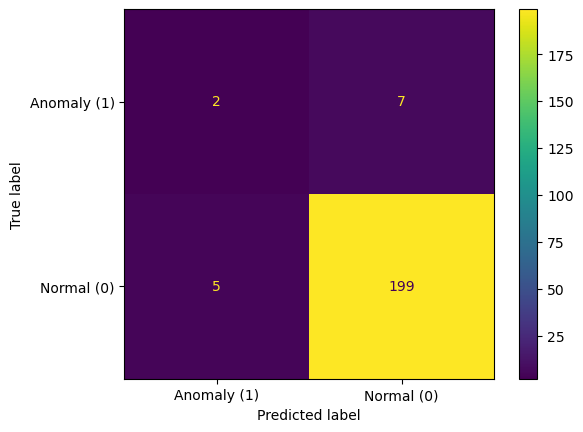

In [21]:
# Split data into training (80%) and testing (20%) sets while maintaining class distribution
trainX, testX, trainy, testy = train_test_split(X, y_binary, test_size=0.25, random_state=42, stratify=y_binary)

# Extract features from raw data for both training and testing sets
trainX_tr, trainy_tr = transform_data(trainX, trainy, label_type='binary')
testX_tr, testy_tr = transform_data(testX, testy, label_type='binary')

# Define parameter grid for Isolation Forest
param_grid = {
    'contamination': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

# Create a custom scorer for Isolation Forest
def custom_isolation_forest_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    # Convert predictions: 1 (inlier) -> 0, -1 (outlier) -> 1
    y_pred_converted = np.where(y_pred == 1, 0, 1)
    return f1_score(y, y_pred_converted, pos_label=1)

# Create a validation set from test data for parameter tuning
valX, testX_final, valy, testy_final = train_test_split(
    testX_tr, testy_tr, test_size=0.5, random_state=42, stratify=testy_tr
)

# Filter training data to only include normal samples (class 0)
trainX_0 = trainX_tr[trainy_tr==0]

# Create a combined dataset for GridSearchCV validation
# We need both normal and anomaly samples for validation
X_combined = np.vstack([trainX_0, valX])
y_combined = np.hstack([np.zeros(trainX_0.shape[0]), valy])

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    IsolationForest(random_state=42),
    param_grid,
    cv=3,
    scoring=custom_isolation_forest_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the combined dataset
grid_search.fit(X_combined, y_combined)

# Get best parameters and model
best_params_IF = grid_search.best_params_
print("Best parameters:", best_params_IF)
print(f"Best validation score: {grid_search.best_score_:.3f}")

# Create a new model with the best parameters
model = IsolationForest(
    contamination=best_params_IF['contamination'],
    n_estimators=best_params_IF['n_estimators'],
    max_samples=best_params_IF['max_samples'],
    max_features=best_params_IF['max_features'],
    random_state=42
)

# Train on all normal training data
model.fit(trainX_0)

# Make predictions on test data
# Isolation Forest returns: 1 for inliers (normal), -1 for outliers (anomalies)
yhat = model.predict(testX_final)

# Convert predictions: 1 (inlier) -> 0, -1 (outlier) -> 1
yhat_converted = np.where(yhat == 1, 0, 1)

# Calculate metrics
prec_1_2 = precision_score(testy_final, yhat_converted, pos_label=1)
rec_1_2 = recall_score(testy_final, yhat_converted, pos_label=1)
f1_1_2 = f1_score(testy_final, yhat_converted, pos_label=1)
gs_bs_1_2 = grid_search.best_score_
print('Test F1 Score: %.3f' % f1_1_2)
print('Test Precision: %.3f' % prec_1_2)
print('Test Recall: %.3f' % rec_1_2)

# Calculate confusion matrix
cm_1_2 = confusion_matrix(testy_final, yhat_converted, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_1_2, display_labels=['Anomaly (1)','Normal (0)'])
disp.plot()
plt.show()

### Experiment 1.3: Binary Classification (Random Forest)

Extracting features:   0%|          | 0/1276 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/426 [00:00<?, ?it/s]

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self.

Best parameters: {'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'rus__sampling_strategy': 0.2, 'smote__sampling_strategy': 0.3}
Best cross-validation F1 score: 0.816
F1 Score: 0.941


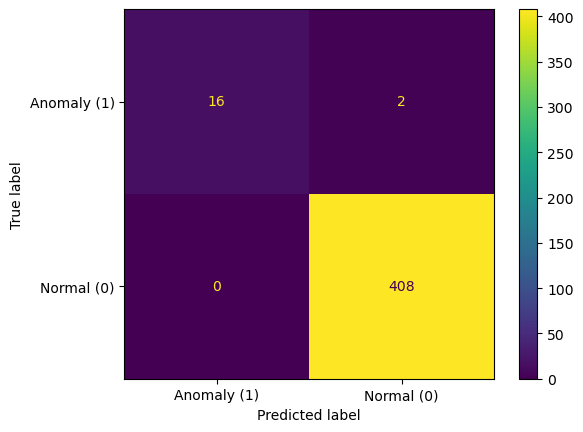

In [22]:
# Split data into training (80%) and testing (20%) sets while maintaining class distribution
trainX, testX, trainy, testy = train_test_split(X, y_binary, test_size=0.25, random_state=42, stratify=y_binary)

# transform data only once to avoid repeated expensive operations
trainX_tr, trainy_tr = transform_data(trainX, trainy, label_type='binary')
testX_tr, testy_tr = transform_data(testX, testy, label_type='binary')

# Parameter grid for Grid Search
param_grid = {
    'rus__sampling_strategy': [0.2, 0.3, 0.5, 0.7],
    'smote__sampling_strategy': [0.2, 0.3, 0.5, 0.7],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

# Use imblearn's Pipeline instead of sklearn's
from imblearn.pipeline import Pipeline

# Create a pipeline with undersampling, SMOTE, and Random Forest
pipeline = Pipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Use F1 score as the scoring metric
f1_scorer = make_scorer(f1_score, pos_label=1)

# Perform grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the preprocessed data (already transformed)
grid_search.fit(trainX_tr, trainy_tr)

best_params_RF = grid_search.best_params_

# Print best parameters and score
print("Best parameters:", best_params_RF)
print("Best cross-validation F1 score: {:.3f}".format(grid_search.best_score_))



# Use the best model for prediction
best_model_rf = grid_search.best_estimator_
yhat = best_model_rf.predict(testX_tr)
prec_1_3 = precision_score(testy_tr, yhat, pos_label=1)
rec_1_3 = recall_score(testy_tr, yhat, pos_label=1)
f1_1_3 = f1_score(testy_tr, yhat, pos_label=1)
gs_bs_1_3 = grid_search.best_score_
print('F1 Score: %.3f' % f1_1_3)

# Calculate confusion matrix
cm_1_3 = confusion_matrix(testy_tr, yhat, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1_3, display_labels=['Anomaly (1)','Normal (0)'])
disp.plot()
plt.show()

### Experiment 1.4: Binary Classification (Light-Gradient Boosting)

In [ ]:
# 1) create a tiny validation fold for early-stopping
from lightgbm import LGBMClassifier

# Split data into training (80%) and testing (20%) sets while maintaining class distribution
trainX, testX, trainy, testy = train_test_split(X, y_binary, test_size=0.25, random_state=42, stratify=y_binary)

# transform data only once to avoid repeated expensive operations
trainX_tr, trainy_tr = transform_data(trainX, trainy, label_type='binary')
testX_tr, testy_tr = transform_data(testX, testy, label_type='binary')

# 2) tighten the grid slightly if you like (optional)
param_grid = {
    'rus__sampling_strategy': [0.2, 0.3, 0.5, 0.7],
    'smote__sampling_strategy': [0.2, 0.3, 0.5, 0.7],
    'lgb__n_estimators': [100, 200, 300],
    'lgb__learning_rate': [0.01, 0.05, 0.1],
    'lgb__num_leaves': [31, 63],
    'lgb__max_depth': [5, 7, -1],
    'lgb__subsample': [0.8, 1.0],
    'lgb__colsample_bytree': [0.8, 1.0]
}

pipeline = Pipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('lgb', LGBMClassifier(random_state=42))
])

# Use F1 score as the scoring metric
f1_scorer = make_scorer(f1_score, pos_label=1)

# Perform grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the preprocessed data (already transformed)
grid_search.fit(trainX_tr, trainy_tr)

best_params_LGBM = grid_search.best_params_
# Print best parameters and score
print("Best parameters:", best_params_LGBM)
print("Best cross-validation F1 score: {:.3f}".format(grid_search.best_score_))

gs_bs_1_4 = grid_search.best_score_
# finally evaluate on your true test set
best = grid_search.best_estimator_
yhat = best.predict(testX_tr)

prec_1_4 = precision_score(testy_tr, yhat, pos_label=1)
rec_1_4 = recall_score(testy_tr, yhat, pos_label=1)
f1_1_4 = f1_score(testy_tr, yhat, pos_label=1)
gs_bs_1_4 = grid_search.best_score_
print('F1 Score: %.3f' % f1_1_4)

# Calculate confusion matrix
cm_1_4 = confusion_matrix(testy_tr, yhat, labels=[1,0])
print("Test F1: %.3f" % f1_score(testy_tr, yhat, pos_label=1))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(testy_tr, yhat, labels=[1,0]),
    display_labels=['Anomaly (1)','Normal (0)']
)

disp.plot(); plt.show()

Extracting features:   0%|          | 0/1276 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/426 [00:00<?, ?it/s]

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


### Experiment 1: Results

In [ ]:
# Create a table with all results
import pandas as pd


# Collect all results
results = [
    {
        "Model": "OneClassSVM",
        "Class": "One Class Classification",
        "Precision": prec_1_1,
        "Recall": rec_1_1,
        "Best Score Validation": 0,
        "F1 Score Test": f1_1_1
    },
    {
        "Model": "Isolation Forest",
        "Class": "One Class Classification",
        "Precision": prec_1_2,
        "Recall": rec_1_2,
        "Best Score Validation": 0,
        "F1 Score Test": f1_1_2
    },
    {
        "Model": "Random Forest",
        "Class": "Binary Classification",
        "Precision": prec_1_3,
        "Recall": rec_1_3,
        "Best Score Validation": gs_bs_1_3,
        "F1 Score Test": f1_1_3
    },
    {
        "Model": "Light Gradient Boosting",
        "Class": "Binary Classification",
        "Precision": prec_1_4,
        "Recall": rec_1_4,
        "Best Score Validation": gs_bs_1_4,
        "F1 Score Test": f1_1_4
    }
]

# Create a DataFrame for display
results_df = pd.DataFrame([
    {
        "Model": r["Model"],
        "Class": r['Class'],
        "Precision": round(r["Precision"], 3),
        "Recall": round(r["Recall"], 3),
        "Best Score Validation": round(r["Best Score Validation"], 3),
        "F1 Score Test": round(r["F1 Score Test"], 3)
        # "Confusion Matrix":  r['Confusion Matrix']
    } for r in results
])

# Display the results table
print("Summary of Results:")
display(results_df)


In [ ]:
# Print best parameters for each model
print("Best parameters for One-Class SVM:")
print(best_params_OCSVM)
print("\nBest parameters for Isolation Forest:")
print(best_params_IF)
print("\nBest parameters for Random Forest:")
print(best_params_RF)
print("\nBest parameters for LightGBM:")
print(best_params_LGBM)


In [ ]:
# Get the best model from grid search
best_params_RF

# Extract feature importances from the Random Forest classifier
feature_importances = best_params_RF.named_steps['rf'].feature_importances_
feature_names = trainX_tr.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and display top 20 features
top_features = importance_df.sort_values('Importance', ascending=False).head(20)
print("Top 20 features selected by the model:")
display(top_features)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][:10], top_features['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
import pickle 
import os
import json
from copy import deepcopy

# Create path to models folder (going up from src to root, then to models)
models_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'models')

# Ensure the models directory exists
os.makedirs(models_path, exist_ok=True)

# Save best model in the models folder
model_path = os.path.join(models_path, 'EXP1_BEST_MODEL.pkl')
pickle.dump(best_model_rf, open(model_path, 'wb'))

# For saving parameters, we need to create a serializable version
# Extract the parameters that are JSON serializable
params = best_model_rf.get_params()
serializable_params = {}

# Create a simplified version with only serializable components
for key, value in params.items():
    if key in ['steps', 'rus', 'smote', 'rf']:
        # Skip complex objects that aren't directly serializable
        continue
    serializable_params[key] = value

# Save the serializable parameters
best_params_path = os.path.join(models_path, 'EXP1_BEST_PARAMS.json')
with open(best_params_path, 'w') as f:
    json.dump(serializable_params, f, indent=4)

print(f"Model saved to: {model_path}")
print(f"Model parameters saved to: {best_params_path}")

# Test loading the model
loaded_model = pickle.load(open(model_path, 'rb'))


In [ ]:
import json, pathlib
pathlib.Path(os.path.join(models_path,"tuned_params.json")).write_text(json.dumps(best_params_RF, indent=2))